# Q-Learning experiment runner

## Imports

In [1]:
%%capture
!pip install tqdm

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import numpy as np
import pandas as pd
from datetime import datetime

In [3]:
from q_maze import QMaze, Action
from e_greedy_policy import EGreedyPolicy
from qlearning import QLearning

from qlearning_exp_functions import Results, train_ql_for_one_episode, run_ql_experiments, train_on_qlearning
from utils import stringify_dict, preprocess_hyperparameters_filename


## Smoke test for QMaze, EGreedyPolicy and running on one episode

In [5]:
qm = QMaze(10)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.5, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [6]:
qm.display(debug=True)

X X X X X X X X X X 
X . X . X . X A X X 
X . X . . . . . . X 
X . X X X . X X . X 
X . X . X . . X . X 
X . . . . . X X X X 
X . X . X . . X X X 
X . X . X . X X . X 
X . X . X . . . . X 
X X X X X X X X O X 

{'maze_width': 10, 'maze_height': 10, 'size': 10, 'has_treasure': False, 'treasure_found': 0, 'treasure_left': 0, 'treasure_map': [], 'position_agent': (1, 7), 'position_entrance': (1, 7), 'position_exit': (9, 8), 'maze': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 2, 1, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 3, 1]]), 'generation_start_coords': (4, 1), 'generation_start_neighbours': [], 'turns_elapsed': 0, 'done': False, 'coord_to_index_state': array([[61, 35,  6, 79, 98, 84, 28, 30, 96, 33

### One iteration to check policy is working with QLearning

557
-2569


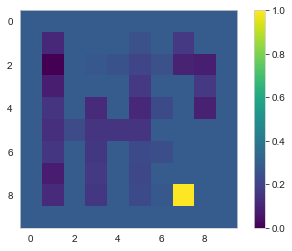

In [7]:
done = False
total_reward = 0

while not done:
    next_action = eg_policy(state, ql.q_value_store)
    next_state, reward, done = qm.step(next_action)
    next_action_index = next_action.value.index
    
    ql.update_q_values(
        current_state=state,
        next_action=next_action_index,
        next_reward=reward,
        next_state=next_state
    )

    eg_policy.update_epsilon()
    state = next_state
    total_reward += reward

print(qm.turns_elapsed)
print(total_reward)
vals = ql.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();

In [8]:
# The maze is solved
qm.display()

X X X X X X X X X X 
X . X . X . X I X X 
X . X . . . . . . X 
X . X X X . X X . X 
X . X . X . . X . X 
X . . . . . X X X X 
X . X . X . . X X X 
X . X . X . X X . X 
X . X . X . . . . X 
X X X X X X X X A X 



## Run for more episodes

Parameterise:
- epsilon for e-greedy
- gamma - discount factor
- alpha - learning rate or memory
- size of maze
- max reward
- decay - constant decay of epsilon

In [4]:
# Some plotting functions which must live here
# because of notebook functionality.
def plot_mean_rewards_episodes(episode_idx: int, experiment_mean_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last mean reward of {experiment_mean_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean reward")
    plt.plot(experiment_mean_rewards)
    plt.show()

def plot_turns_elapsed_episodes(episode_idx: int, experiment_mean_turns_elapsed: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last turns elapsed of {experiment_mean_turns_elapsed[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean turns elapsed")
    plt.plot(experiment_mean_turns_elapsed)
    plt.show()

 51%|█████     | 51/100 [00:08<00:03, 12.92it/s]Run: 40, ending epsilon: 0.0900567811781995, mean reward: 3.45, mean turns elapsed: 24.3, std reward: 138.5752052136312
Run: 50, ending epsilon: 0.0900567811781995, mean reward: 35.84, mean turns elapsed: 17.98, std reward: 57.7161537180017
100%|██████████| 100/100 [00:09<00:00, 10.69it/s]Run: 80, ending epsilon: 0.0900567811781995, mean reward: 48.21, mean turns elapsed: 15.57, std reward: 21.177957880777832
Run: 90, ending epsilon: 0.0900567811781995, mean reward: 48.62, mean turns elapsed: 14.97, std reward: 26.110833000882984



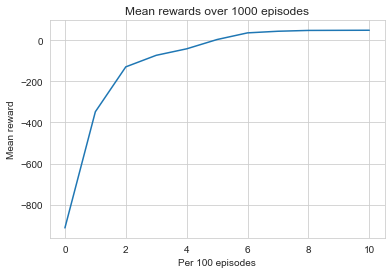

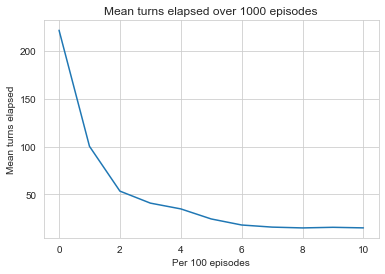

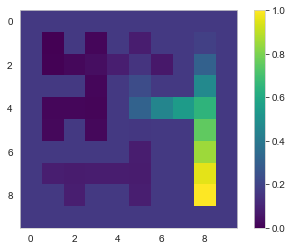

In [8]:
# Logging stuff
RESULTS_PATH = "results"
dt_now = datetime.now()
dt_str = dt_now.strftime("%Y%m%d-%H%M%S")

OUTPUT_PATH = os.path.join(RESULTS_PATH, dt_str)

if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = 1000//LOGGING_STEP_SIZE

ENV_SIZE_LIST = [10, 15, 20, 25, 30]
EPSILON_LIST = [0.6, 0.7, 0.8]
DECAY_LIST = [0.9, 0.8, 0.7]
GAMMA_LIST = [0.9, 0.8, 0.7]
ALPHA_LIST = [0.01, 0.02, 0.03]

for env_size in ENV_SIZE_LIST:
    for epsilon in EPSILON_LIST:
        for decay in DECAY_LIST:
            for gamma in GAMMA_LIST:
                for alpha in ALPHA_LIST:
                    train_on_qlearning(
                        env_size=env_size,
                        epsilon=epsilon,
                        decay=decay,
                        gamma=gamma,
                        alpha=alpha,
                        num_runs_tqdm=NUM_RUNS_TQDM,
                        logging_step_size=LOGGING_STEP_SIZE,
                        num_logged_episodes=NUM_LOGGED_EPISODES,
                        num_episodes=NUM_EPISODES,
                        output_path=OUTPUT_PATH
                    )



## Test QMaze number of steps for different environment sizes